# Relative hydration free energy

In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import jupyter_black

In [3]:
jupyter_black.load()

In [4]:
from importlib import resources

import diskcache
from jax import grad, jit, vmap
import jax.numpy as jnp
import mols2grid
import numpy as np
import pymbar
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from tqdm import tqdm

from timemachine.constants import BOLTZ, DEFAULT_FF, KCAL_TO_KJ
from timemachine.fe import atom_mapping
from timemachine.fe.rbfe import HostConfig, estimate_relative_free_energy
from timemachine.fe.single_topology_v3 import SingleTopologyV3
from timemachine.fe.system import minimize_scipy
from timemachine.fe.utils import get_mol_name, get_romol_conf, plot_atom_mapping_grid
from timemachine.ff import Forcefield
from timemachine.integrator import LangevinIntegrator
from timemachine.md.builders import build_water_system

In [5]:
cache = diskcache.Cache(".cache")

In [6]:
# hif2a ligands
with resources.path("timemachine.testsystems.data", "ligands_40.sdf") as path:
    suppl = Chem.SDMolSupplier(str(path), removeHs=False)
    mols = {get_mol_name(mol): mol for mol in suppl}

In [7]:
mol_a = mols["1"]
mol_b = mols["256"]

In [8]:
mols2grid.display([mol_a, mol_b])

In [9]:
def compute_atom_mapping(mcs_threshold=2.0):
    mcs_result = atom_mapping.mcs(mol_a, mol_b, threshold=mcs_threshold)
    query_mol = Chem.MolFromSmarts(mcs_result.smartsString)
    return atom_mapping.get_core_by_mcs(
        mol_a, mol_b, query_mol, threshold=mcs_threshold
    )

In [10]:
core = compute_atom_mapping()

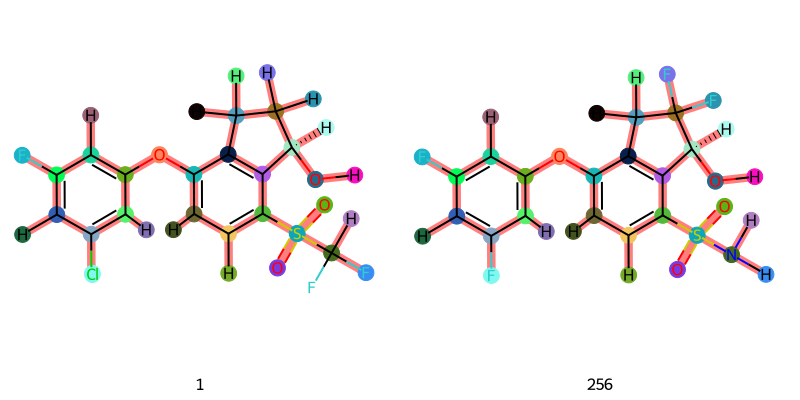

In [11]:
plot_atom_mapping_grid(mol_a, mol_b, core)

In [12]:
forcefield = Forcefield.load_from_file(DEFAULT_FF)

## Vacuum leg

In [13]:
st = SingleTopologyV3(mol_a, mol_b, core, forcefield)

In [14]:
init_conf = st.combine_confs(get_romol_conf(mol_a), get_romol_conf(mol_b))
masses = np.array(st.combine_masses())

In [15]:
lambdas = np.linspace(0, 1, 16)

In [16]:
@cache.memoize()
def optimize_initial_conformations():
    return [minimize_scipy(U_fn, init_conf) for U_fn in tqdm(U_fns)]

In [17]:
U_fns = [st.setup_intermediate_state(lam).get_U_fn() for lam in lambdas]
U_fns = [jit(U_fn) for U_fn in U_fns]

In [18]:
init_confs = optimize_initial_conformations()

100%|██████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.15s/it]


In [19]:
temperature = 300.0

In [20]:
def sample(
    U_fn,
    x0,
    n_samples=100,
    steps_per_sample=1000,
):
    grad_U = grad(U_fn)

    @jit
    def force(x):
        return -grad_U(x)

    integ = LangevinIntegrator(force, masses, temperature, dt=1.5e-3, friction=1.0)

    xs = [x0]
    v = jnp.zeros_like(x0)

    for _ in range(n_samples):
        xs_, vs_ = integ.multiple_steps(xs[-1], v, steps_per_sample)
        xs.append(xs_[-1])
        v = vs_[-1]

    return xs

In [21]:
@cache.memoize()
def simulate():
    confs_kn = [sample(U_fn, x0) for U_fn, x0 in zip(U_fns, tqdm(init_confs))]
    confs_kn = jnp.array(confs_kn)
    return confs_kn

In [22]:
confs_kn = simulate()

 94%|█████████████████████████████████████████████████████████████████████████▏    | 15/16 [03:44<00:14, 14.95s/it]


In [23]:
confs_kn.shape  # (state, sample, atom, xyz)

(16, 101, 37, 3)

In [24]:
def compute_pair_BAR_dGs(confs_kn):

    beta = 1 / BOLTZ / temperature

    batched_reduced_potentials = [
        vmap(lambda x, U_fn=U_fn: beta * U_fn(x)) for U_fn in U_fns
    ]

    def pairs(x):
        x = list(x)
        return zip(x, x[1:])

    dGs, dG_errs = (
        np.array(
            [
                pymbar.BAR(
                    w_F=u1(x0) - u0(x0),
                    w_R=u0(x1) - u1(x1),
                )
                for (u0, x0), (u1, x1) in pairs(
                    zip(batched_reduced_potentials, confs_kn)
                )
            ]
        ).T
        / KCAL_TO_KJ
    )

    return dGs, dG_errs

In [25]:
vacuum_dGs, vacuum_dG_errs = compute_pair_BAR_dGs(confs_kn)

In [26]:
vacuum_dG = vacuum_dGs.sum()
vacuum_dG_err = np.linalg.norm(vacuum_dG_errs)
vacuum_dG, vacuum_dG_err

(-18.276247126697044, 0.23862837279392424)

## Solvent leg

         Current function value: -103356.174220
         Iterations: 78
         Function evaluations: 143
         Gradient evaluations: 129
         Current function value: -103360.250308
         Iterations: 80
         Function evaluations: 167
         Gradient evaluations: 155
1_256_solvent BAR: lambda 0 -> 1 dG: -1.222 +- 0.029 kJ/mol
         Current function value: -103362.345403
         Iterations: 77
         Function evaluations: 175
         Gradient evaluations: 163
1_256_solvent BAR: lambda 1 -> 2 dG: -1.299 +- 0.029 kJ/mol
         Current function value: -103368.845752
         Iterations: 79
         Function evaluations: 160
         Gradient evaluations: 149
1_256_solvent BAR: lambda 2 -> 3 dG: -2.830 +- 0.058 kJ/mol
         Current function value: -103375.029305
         Iterations: 75
         Function evaluations: 159
         Gradient evaluations: 149
1_256_solvent BAR: lambda 3 -> 4 dG: -3.052 +- 0.064 kJ/mol
         Current function value: -103375.520540
  

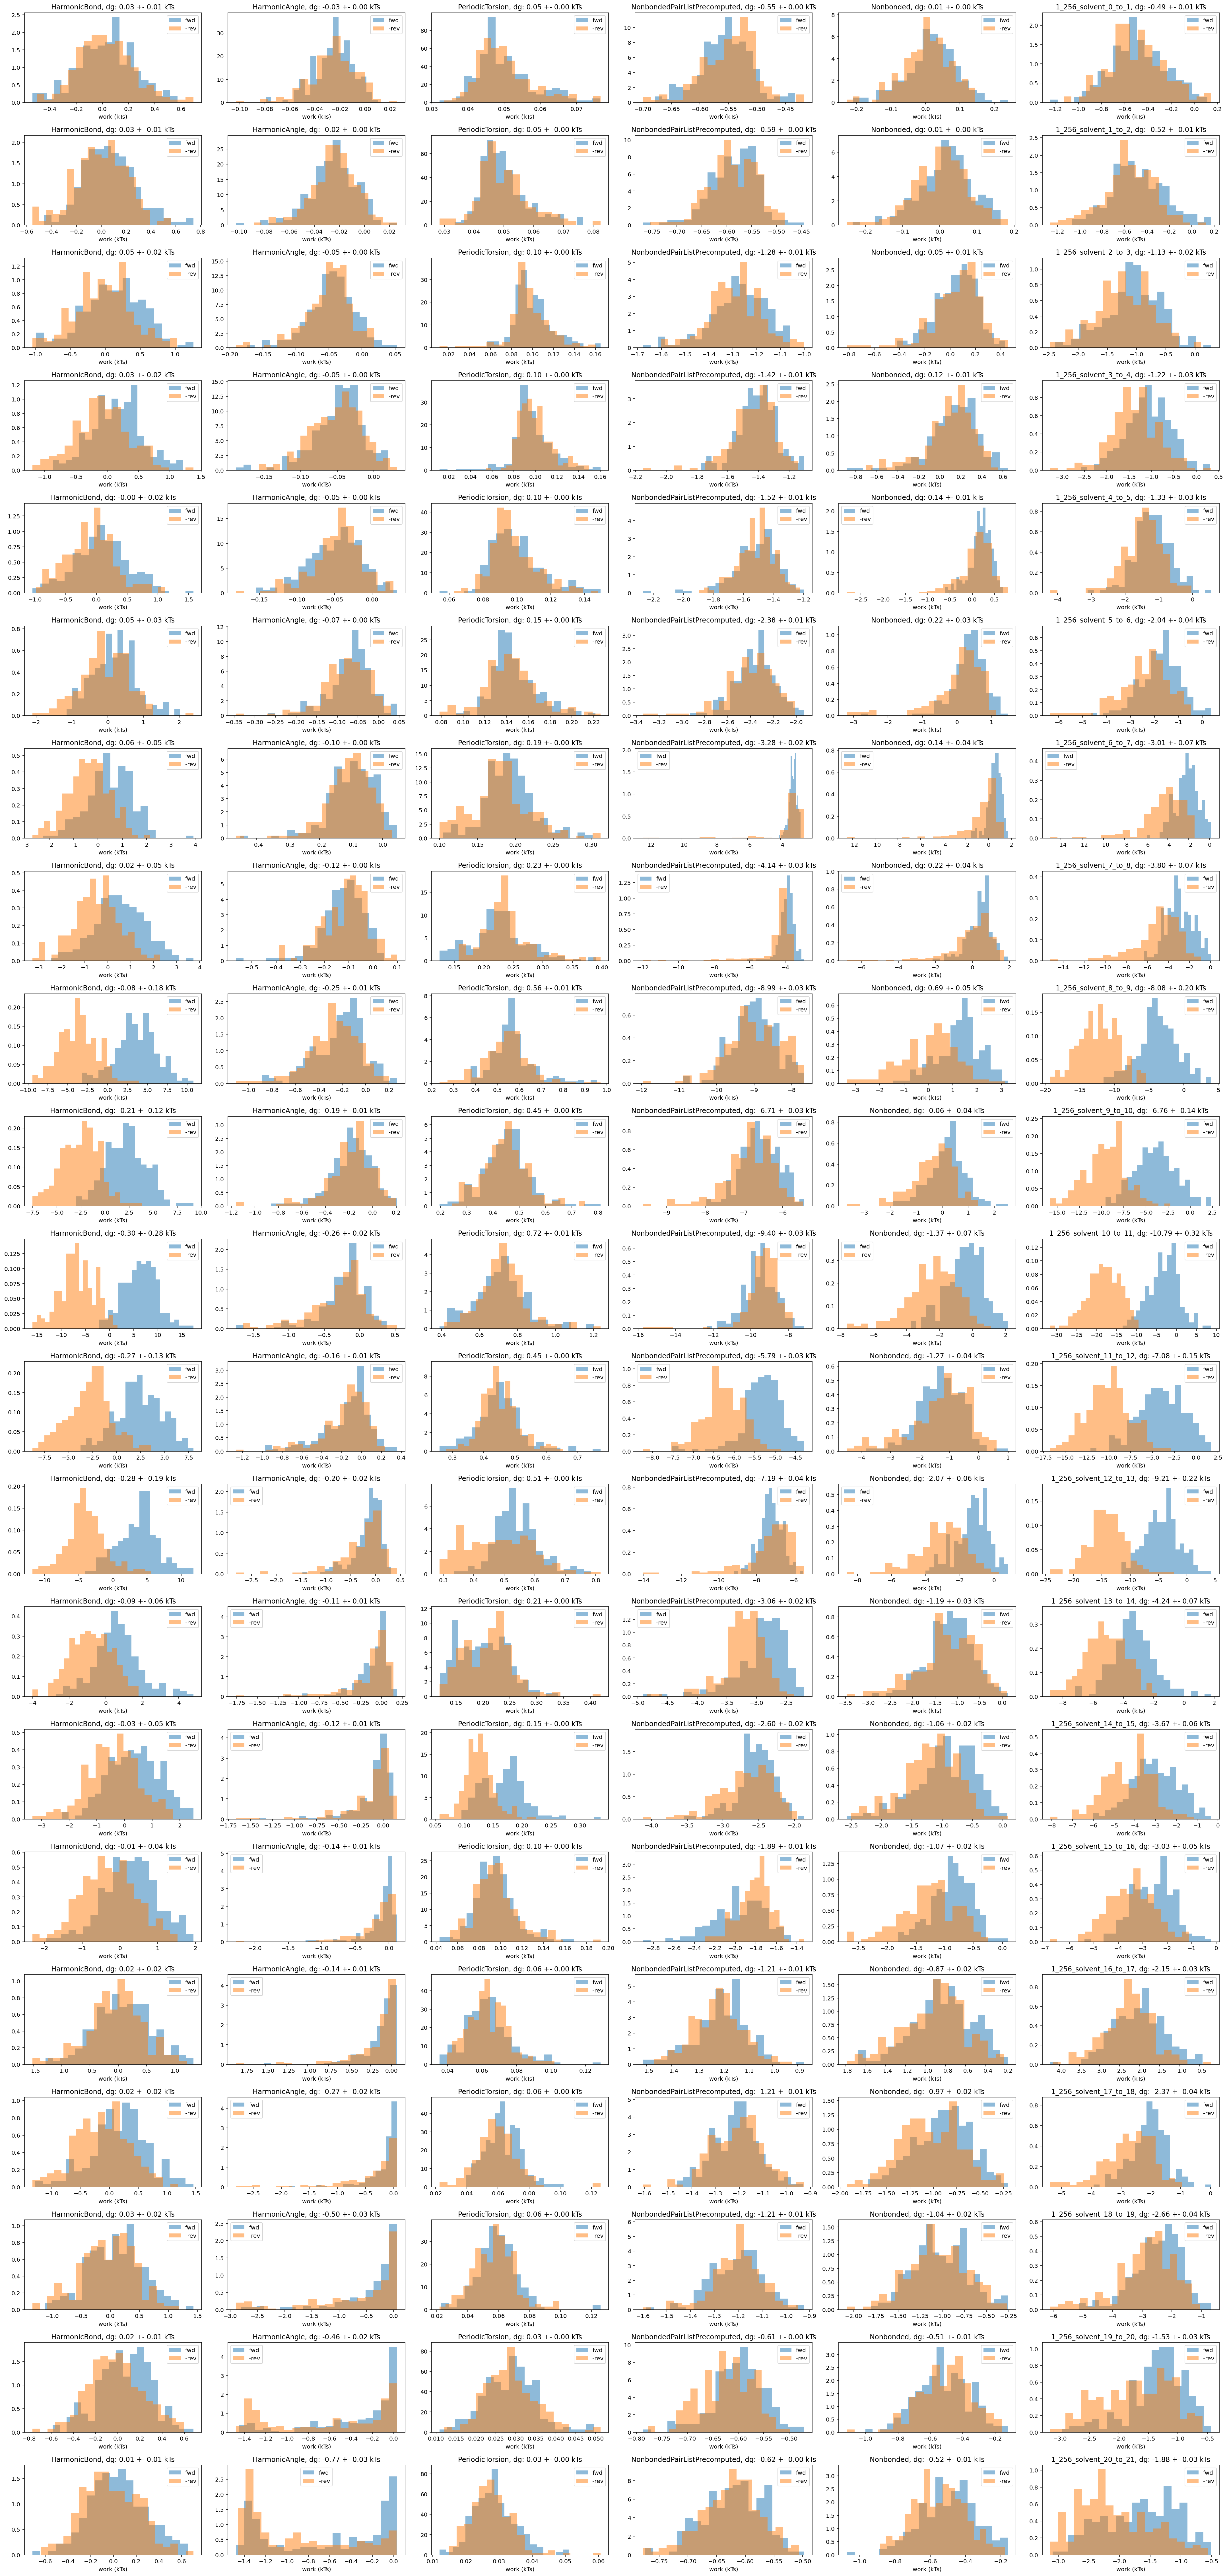

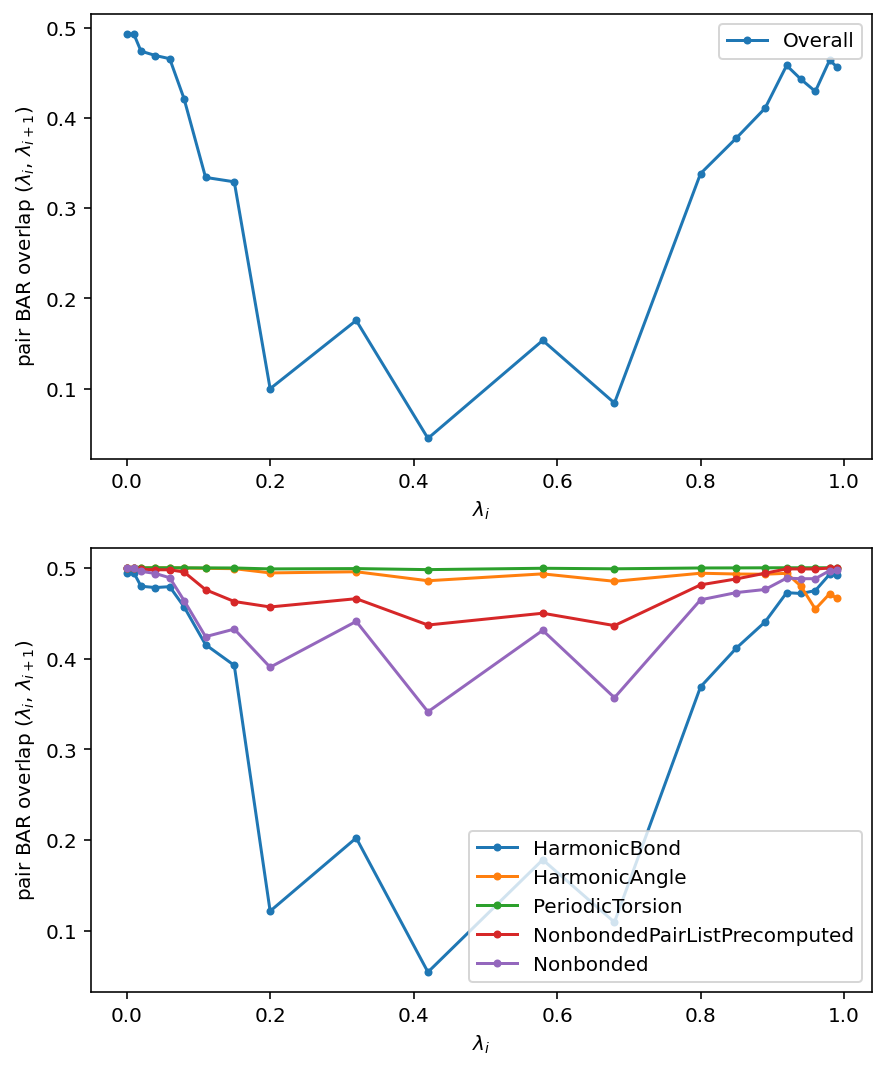

In [27]:
%%time
solvent_sys, solvent_conf, solvent_box, solvent_top = build_water_system(box_width=4.0)
solvent_box += np.diag([0.1, 0.1, 0.1])  # remove any possible clashes
solvent_host_config = HostConfig(solvent_sys, solvent_conf, solvent_box)

solvent_res = estimate_relative_free_energy(
    mol_a,
    mol_b,
    core,
    forcefield,
    solvent_host_config,
    seed=123,
    n_frames=200,
    prefix="solvent",
    n_eq_steps=10000,
)

In [28]:
solvent_dG = np.array(solvent_res.all_dGs).sum() / KCAL_TO_KJ
solvent_dG_err = np.linalg.norm(solvent_res.all_errs) / KCAL_TO_KJ
solvent_dG, solvent_dG_err

(-45.90330223965517, 0.303680867390009)

## $\Delta \Delta G_{\text{hyd}}$

In [29]:
ddG = solvent_dG - vacuum_dG
ddG_err = np.linalg.norm([solvent_dG_err, vacuum_dG_err])
ddG, ddG_err

(-27.627055112958125, 0.3862195871793976)